# Notebook 1: Obtención y Unificación de Datos

## Objetivo
Este notebook descarga y unifica **dos datasets médicos** para crear un conjunto de datos robusto y balanceado:

### Datasets Utilizados:

1. **CodiEsp** (Dataset principal)
   - Fuente: Hugging Face (`bigbio/codiesp`)
   - Idioma: Español
   - Contenido: Casos clínicos reales del sistema de salud español con códigos CIE-10
   - Procesamiento: Se extrae el código CIE-10 y se mapea a especialidades médicas

2. **MTSamples** (Dataset complementario - Data Augmentation)
   - Fuente: Archivo CSV local (ya traducido del inglés al español)
   - Idioma: Español (traducción automática del original en inglés)
   - Contenido: Transcripciones médicas de Estados Unidos
   - Propósito: Enriquecer clases minoritarias y mejorar la generalización del modelo

### Flujo del Notebook:

1. Descargar y procesar CodiEsp desde Hugging Face
2. Cargar MTSamples traducido desde archivo local
3. Unificar ambos datasets
4. Guardar el dataset combinado para el siguiente paso (Procesamiento NLP)

---

In [ ]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt

# Configuración para que las tablas se vean esteticamente agradables
pd.set_option('display.max_colwidth', 150)
print("Librerías importadas correctamente.")

c:\Users\yam29\Documents\GitHub\SIC-Clasificador-de-urgencias-medicas-basado-en-la-interpretacion-de-sintomas-mediante-IA\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Librerías importadas correctamente.


---
## 📦 Paso 1: Descarga del Dataset CodiEsp

CodiEsp es un corpus de casos clínicos en español con códigos CIE-10 (Clasificación Internacional de Enfermedades).
Los códigos se mapean a especialidades médicas según la primera letra del código.

In [2]:
print("⏳ Descargando dataset CodiEsp desde HuggingFace...")

# Carga del dataset 'bigbio/codiesp'
ds = load_dataset("bigbio/codiesp", "codiesp_D_bigbio_text", trust_remote_code=True)

print("✅ ¡Descarga completada!")
print("Estructura del dataset:", ds)

⏳ Descargando dataset CodiEsp desde HuggingFace...


Generating validation split: 100%|██████████| 250/250 [00:00<00:00, 60903.53 examples/s]

✅ ¡Descarga completada!
Estructura del dataset: DatasetDict({
    train: Dataset({
        features: ['id', 'document_id', 'text', 'labels'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'document_id', 'text', 'labels'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['id', 'document_id', 'text', 'labels'],
        num_rows: 250
    })
})


In [ ]:
# 1. Convertir la parte de 'train' (entrenamiento) a un DataFrame
df = pd.DataFrame(ds['train'])

# 2. Extraer el código principal de la columna 'labels'
def obtener_primer_codigo(lista_labels):
    # A veces la lista puede venir vacía, así que se valida
    if isinstance(lista_labels, list) and len(lista_labels) > 0:
        return lista_labels[0] # Retorna ej: 'n40'
    return None

df['codigo_cie10'] = df['labels'].apply(obtener_primer_codigo)

# Eliminar filas que no tengan código
df = df.dropna(subset=['codigo_cie10'])
df = df[['text', 'codigo_cie10']] # Nos quedamos solo con lo útil

# 3. DICCIONARIO DE TRIAJE (Mapeo a Especialidades)
# Agrupar los códigos CIE-10 por su letra inicial para definir la especialidad médica
mapa_especialidades = {
    'A': 'Infecciosas/Parasitarias',
    'B': 'Infecciosas/Parasitarias',
    'C': 'Oncología (Tumores)',
    'D': 'Sangre/Inmunología',
    'E': 'Endocrinología/Nutrición',
    'F': 'Psiquiatría/Mental',
    'G': 'Neurología',
    'H': 'Oftalmología/ORL',
    'I': 'Cardiología/Circulatorio',
    'J': 'Respiratorio/Neumología',
    'K': 'Gastroenterología/Digestivo',
    'L': 'Dermatología',
    'M': 'Traumatología/Muscular',
    'N': 'Urología/Renal',
    'O': 'Ginecología/Obstetricia',
    'R': 'Síntomas Generales/No clasificados',
    'S': 'Traumatología/Lesiones',
    'T': 'Toxicología/Lesiones'
}

# Funcion para aplicar el mapeo
def clasificar_especialidad(codigo):
    if not codigo: return 'Otros'
    letra = str(codigo)[0].upper() # Tomar la primera letra (ej: 'J' de 'J45')
    return mapa_especialidades.get(letra, 'Otros')

# Crear la columna 'especialidad'
df['especialidad'] = df['codigo_cie10'].apply(clasificar_especialidad)

# Renombrar la columna 'text' para que sea más claro
df = df.rename(columns={'text': 'sintomas'})

print(f"✅ Datos procesados. Tenemos {len(df)} casos clínicos limpios.")
display(df.head(3))

✅ Datos procesados. Tenemos 500 casos clínicos limpios.


,sintomas,codigo_cie10,especialidad
0,Describimos el caso de un varón de 37 años con vida previa activa que refiere dolores osteoarticulares de localización variable en el último mes y...,n44.8,Urología/Renal
1,Se trata de una mujer de 29 años sometida a un estudio ecográfico pélvico de control tras una ligadura de trompas por vía laparoscópica. Durante e...,d30.3,Sangre/Inmunología
2,"Varón de 36 años, sin antecedentes de interés, que fue estudiado en la consulta de medicina interna por presentar masa inguinoescrotal izquierda d...",r19.00,Síntomas Generales/No clasificados


,sintomas,especialidad
209,"Se presenta el caso de un varón de 24 años de edad, que acude a urgencias por disminución de la AV bilateral y cefalea de dos días de evolución. C...",Oftalmología/ORL
395,"Varón joven de 20 años, con antecedentes desde los 6 años de crisis epilépticas parciales con generalización y mal control medicamentoso (en el mo...",Neurología
172,"Un paciente varón de 76 años acude a consulta de oftalmología por presentar dolor, lagrimeo y secreción en ojo izquierdo (OI) asociados a ojo rojo...",Oftalmología/ORL
453,"Niño previamente sano. Como únicos antecedentes, fue operado de criptorquidia izquierda; está vacunado correctamente para su edad. Con cinco años ...",Síntomas Generales/No clasificados
249,Varón de 63 años sin antecedentes de interés. Consultó por presentar una lesión nodular a nivel del cuadrante dorso-lumbar derecho de un mes de ev...,Síntomas Generales/No clasificados


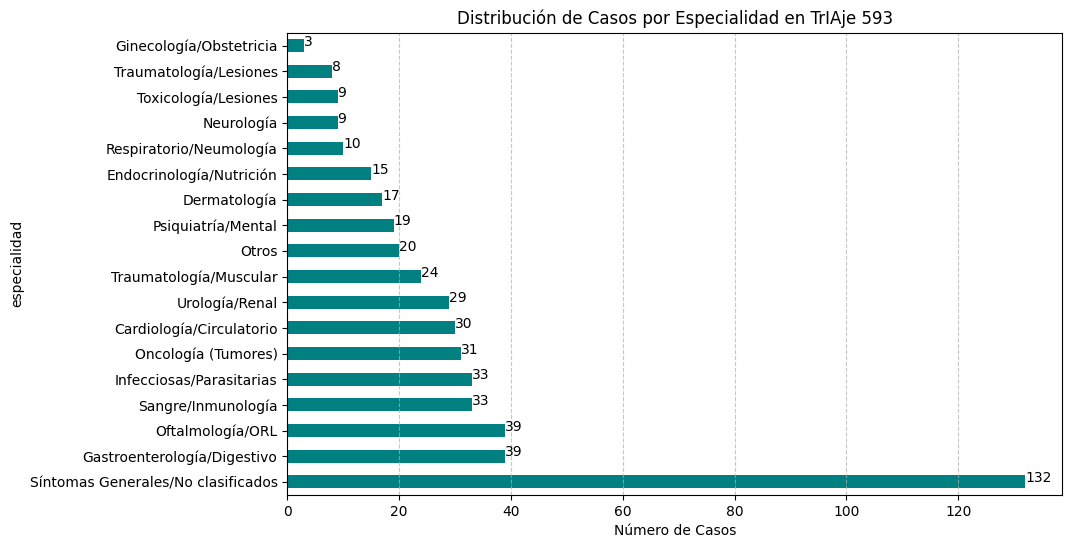

In [ ]:
# Mostrar 5 ejemplos aleatorios
display(df[['sintomas', 'especialidad']].sample(5))

# Ver cuántos casos se tiene por especialidad (Importante para saber si está balanceado)
plt.figure(figsize=(10,6))
df['especialidad'].value_counts().plot(kind='barh', color='teal')
plt.title('Distribución de Casos por Especialidad en TrIAje 593')
plt.xlabel('Número de Casos')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar los valores en el gráfico
conteo = df['especialidad'].value_counts().values
for index, value in enumerate(conteo):
    plt.text(value, index, str(value))

plt.show()

In [ ]:
# Guardar temporalmente CodiEsp (se unificará con MTSamples después)
df.to_csv('../data/processed/datos_triaje_limpios.csv', index=False)
print("✅ Archivo 'datos_triaje_limpios.csv' guardado (solo CodiEsp)")
print(f"📊 Total: {len(df)} casos del dataset CodiEsp")

NameError: name 'df' is not defined

In [ ]:
# Guardar el dataset unificado para los siguientes pasos del pipeline
df_unificado.to_csv('../data/processed/datos_triaje_unificados.csv', index=False)
print("✅ Archivo 'datos_triaje_unificados.csv' guardado exitosamente en /data/processed")
print(f"📄 Contiene {len(df_unificado)} casos clínicos listos para procesamiento NLP.")

In [ ]:
# Visualización de la distribución unificada
plt.figure(figsize=(12,8))
df_unificado['especialidad'].value_counts().plot(kind='barh', color='steelblue')
plt.title('Distribución de Casos en Dataset Unificado (CodiEsp + MTSamples)', fontsize=14, fontweight='bold')
plt.xlabel('Número de Casos')
plt.ylabel('Especialidad Médica')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Mostrar los valores en las barras
conteo_unificado = df_unificado['especialidad'].value_counts().values
for index, value in enumerate(conteo_unificado):
    plt.text(value + 20, index, str(value), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
print("🔗 Unificando datasets CodiEsp + MTSamples...")

# Asegurarnos de que ambos tengan las mismas columnas
df_codiesp = df[['sintomas', 'especialidad']]  # Dataset CodiEsp procesado anteriormente
df_mtsamples_clean = df_mtsamples[['sintomas', 'especialidad']]

# Combinar ambos datasets verticalmente (concatenar filas)
df_unificado = pd.concat([df_codiesp, df_mtsamples_clean], ignore_index=True)

# Eliminar duplicados si existen
df_unificado = df_unificado.drop_duplicates(subset=['sintomas'], keep='first')

# Eliminar filas con valores nulos
df_unificado = df_unificado.dropna()

print(f"✅ Unificación completada!")
print(f"Total de casos CodiEsp: {len(df_codiesp)}")
print(f"Total de casos MTSamples: {len(df_mtsamples_clean)}")
print(f"Total de casos unificados: {len(df_unificado)}")
print("\n📊 Distribución final por especialidad:")
display(df_unificado['especialidad'].value_counts())

---
## 🔗 Paso 3: Unificación de Ambos Datasets

Ahora combinamos **CodiEsp** (casos españoles) con **MTSamples** (casos traducidos) para crear un dataset robusto y balanceado.

In [ ]:
print("⏳ Cargando dataset MTSamples (ya traducido al español)...")

# Cargar el dataset MTSamples que ya fue traducido del inglés al español
df_mtsamples = pd.read_csv('../data/raw/mtsamples_translated.csv')

print(f"✅ Dataset MTSamples cargado. Total de casos: {len(df_mtsamples)}")
print("\nDistribución de especialidades en MTSamples:")
print(df_mtsamples['especialidad'].value_counts())
display(df_mtsamples.head(3))

---
## 📦 Paso 2: Carga del Dataset MTSamples (Traducido)

El dataset **MTSamples** contiene transcripciones médicas en inglés que ya fueron traducidas al español.
Este dataset complementa a CodiEsp para enriquecer las clases minoritarias mediante **Data Augmentation**.

---
## ✅ Resumen del Proceso

### Archivos Generados:

1. **`datos_triaje_limpios.csv`** - Solo CodiEsp procesado (archivo intermedio)
2. **`datos_triaje_unificados.csv`** ⭐ - **Dataset final unificado** (CodiEsp + MTSamples)

### 📌 Siguiente Paso:
Ejecuta el **Notebook 2: Preprocesamiento NLP** para aplicar limpieza avanzada de texto médico al dataset unificado.

### 📊 Pipeline Completo:
```
Notebook 1: Obtención de Datos
  ├── CodiEsp (Hugging Face) → datos_triaje_limpios.csv
  ├── MTSamples (CSV traducido)
  └── Unificación → datos_triaje_unificados.csv ✅
           ↓
Notebook 2: Preprocesamiento NLP
  └── datos_nlp_procesados_aumentados.csv ✅
           ↓
Notebook 3: Entrenamiento
  └── Modelo SVM + Label Encoder
```